# digit-recognizer

https://www.kaggle.com/competitions/digit-recognizer

## Setup

In [1]:
import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

import torchinfo

In [2]:
IS_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
COMP_NAME = 'digit-recognizer'

if COMP_NAME is None:
    raise NameError('COMP_NAME has not been initialized')

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

BATCH_SIZE = 100

DATA_PATH = Path('../input/' + COMP_NAME) if IS_KAGGLE else Path('./data')

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
print('kaggle:', 'Y' if IS_KAGGLE else 'N')
print('torch version:', torch.__version__)
print('device:', DEVICE)
print(torch.cuda.device_count(), 'GPU(s) available')

kaggle: N
torch version: 2.0.1
device: cuda:0
2 GPU(s) available


## Load Data

https://www.kaggle.com/competitions/digit-recognizer/data

In [4]:
path = Path('./data')
if not DATA_PATH.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(COMP_NAME)
    zipfile.ZipFile(f'{COMP_NAME}.zip').extractall(DATA_PATH)

In [5]:
train_data = pd.read_csv(DATA_PATH / 'train.csv')
test_data = pd.read_csv(DATA_PATH / 'test.csv')

print('train:', train_data.shape)
print('test: ', test_data.shape)

train: (42000, 785)
test:  (28000, 784)


In [6]:
X = train_data.iloc[:, train_data.columns != 'label']
y = train_data.label.values

print('X:', X.shape, type(X))
print('y:', y.shape, type(y))

X: (42000, 784) <class 'pandas.core.frame.DataFrame'>
y: (42000,) <class 'numpy.ndarray'>


## Data Exploration

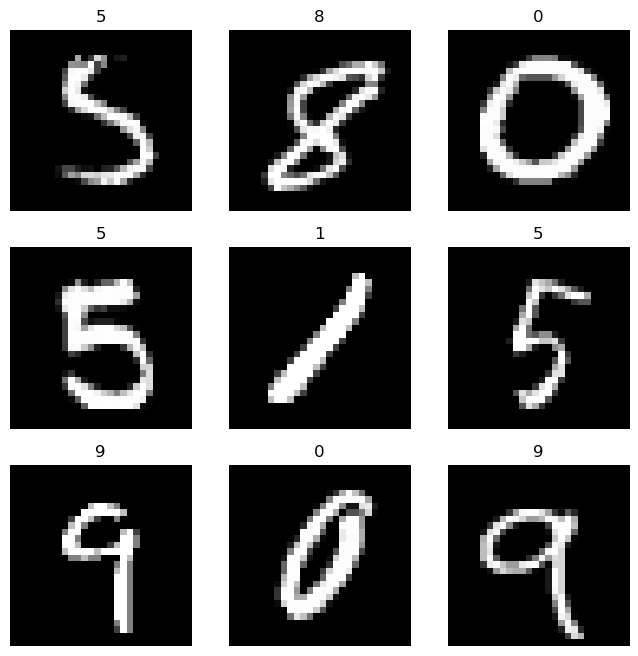

In [7]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample = random.randint(0, len(X)-1)
    label = str(int(y[sample]))
    img = X.values[sample].reshape(28,28)
    
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

In [8]:
train_data['label'].value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

## Prepare Training/Validation Data

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_valid:', X_valid.shape, 'y_valid:', y_valid.shape)

X_train: (33600, 784) y_train: (33600,)
X_valid: (8400, 784) y_valid: (8400,)


In [10]:
# normalize (0-255 -> 0-1)

X_train = X_train.values / 255
X_valid = X_valid.values / 255

In [11]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)

X_valid = torch.from_numpy(X_valid)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)

print('X_train.dtype:', X_train.dtype)
print('y_train.dtype:', y_train.dtype)

X_train.dtype: torch.float64
y_train.dtype: torch.int64


In [12]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
valid_ds = torch.utils.data.TensorDataset(X_valid, y_valid)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

## Build Model

In [13]:
class DigitRecognizerModel(nn.Module):
    """
    Architecture summary:
      - Layer 1: Convolution 1 > Activation (ReLU) > Pooling 1 > Dropout 1
      - Layer 2: Convolution 2 > Activation (ReLU) > Pooling 2 > Dropout 2 > Flatten
      - Layer 3: Linear 1 > Activation (ReLU) > Dropout 3
      - Layer 4: Linear 2 > Activation (ReLU) > Dropout 4
      - Layer 5: Output > Activation (Softmax)
    """
    
    def __init__(self):
        super().__init__()

        # layer 1 
        # (black and white image, 1 color channel == 1 input channel)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.drop1 = nn.Dropout(p=0.3)

        # layer 2
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=224, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.drop2 = nn.Dropout(p=0.4)

        # layer 3
        self.linear1 = nn.Linear(in_features=224 * 4 * 4, out_features=64)
        self.drop3 = nn.Dropout(p=0.4)

        # layer 4
        self.linear2 = nn.Linear(in_features=64, out_features=32)
        self.drop4 = nn.Dropout(p=0.4)

        # layer 5
        self.linear3 = nn.Linear(in_features=32, out_features=10)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.drop1(self.pool1(F.relu(self.conv1(x)))) # layer 1
        out = self.drop2(self.pool2(F.relu(self.conv2(out)))) # layer 2
        out = out.view(-1, 224 * 4 * 4) # flatten layer 2 outputs since layer 3 is linear
        
        out = self.drop3(F.relu(self.linear1(out))) # layer 3
        out = self.drop4(F.relu(self.linear2(out))) # layer 4
        # out = self.softmax(self.linear3(out)) # layer 5
        out = self.linear3(out) # logits
        return out

In [14]:
model = DigitRecognizerModel().to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

DigitRecognizerModel(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(128, 224, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.4, inplace=False)
  (linear1): Linear(in_features=3584, out_features=64, bias=True)
  (drop3): Dropout(p=0.4, inplace=False)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (drop4): Dropout(p=0.4, inplace=False)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)


In [15]:
torchinfo.summary(model, (1, 28, 28), col_names=('input_size', 'output_size', 'num_params', 'kernel_size'), verbose=0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
DigitRecognizerModel                     [1, 28, 28]               [1, 10]                   --                        --
├─Conv2d: 1-1                            [1, 28, 28]               [128, 24, 24]             3,328                     [5, 5]
├─MaxPool2d: 1-2                         [128, 24, 24]             [128, 12, 12]             --                        [2, 2]
├─Dropout: 1-3                           [128, 12, 12]             [128, 12, 12]             --                        --
├─Conv2d: 1-4                            [128, 12, 12]             [224, 8, 8]               717,024                   [5, 5]
├─MaxPool2d: 1-5                         [224, 8, 8]               [224, 4, 4]               --                        [2, 2]
├─Dropout: 1-6                           [224, 4, 4]               [224, 4, 4]               --                        -

## Train Model

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer, print_every=100):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X = (X.view(-1, 1, 28, 28)).type(torch.FloatTensor).to(DEVICE)
        y = y.to(DEVICE)

        logits = model(X)
        loss = loss_fn(logits, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # print results
        if batch % print_every == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

In [17]:
def valid_loop(dataloader, model, loss_fn, print_every=100):
    size = len(dataloader.dataset)
    model.eval()
    batches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = (X.view(-1, 1, 28, 28)).type(torch.FloatTensor).to(DEVICE)
            y = y.to(DEVICE)

            logits = model(X)
            loss += loss_fn(logits, y).item()
            correct += (logits.argmax(1) == y).type(torch.float).sum().item()

    loss /= BATCH_SIZE
    correct /= size
    print(f'Validation: Accuracy={(100*correct):>0.1f}%, Average_Loss={loss:>8f}\n')

In [18]:
epochs = 10

for epoch in range(epochs):
    print(f'Epoch {epoch+1}\n-------------------------------')
    train_loop(train_loader, model, loss_fn, optimizer)
    valid_loop(valid_loader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.290158 [  100/33600]
loss: 0.779308 [10100/33600]
loss: 0.512162 [20100/33600]
loss: 0.319611 [30100/33600]
Validation: Accuracy=96.8%, Average_Loss=0.101270

Epoch 2
-------------------------------
loss: 0.241113 [  100/33600]
loss: 0.325025 [10100/33600]
loss: 0.323316 [20100/33600]
loss: 0.231328 [30100/33600]
Validation: Accuracy=98.0%, Average_Loss=0.059262

Epoch 3
-------------------------------
loss: 0.176649 [  100/33600]
loss: 0.190975 [10100/33600]
loss: 0.303267 [20100/33600]
loss: 0.130003 [30100/33600]
Validation: Accuracy=98.4%, Average_Loss=0.050965

Epoch 4
-------------------------------
loss: 0.159528 [  100/33600]
loss: 0.206334 [10100/33600]
loss: 0.166055 [20100/33600]
loss: 0.237737 [30100/33600]
Validation: Accuracy=98.4%, Average_Loss=0.047184

Epoch 5
-------------------------------
loss: 0.318449 [  100/33600]
loss: 0.061951 [10100/33600]
loss: 0.081967 [20100/33600]
loss: 0.245102 [30100/33600]
Validation: Accu

## Submission

In [19]:
X_test = test_data.values
X_test = torch.from_numpy(X_test / 255)

y_test = np.zeros(X_test.shape)
y_test = torch.from_numpy(y_test)

test_ds = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
submission_rows = [['ImageId', 'Label']]

with torch.no_grad():
    model.eval()
    image_id = 1

    for X, _ in test_loader:
        X = (X.view(-1, 1, 28, 28)).type(torch.FloatTensor).to(DEVICE)
        preds = model(X).argmax(1)

        for pred in preds:
            submission_rows.append([image_id, pred.item()])
            image_id += 1

submission = pd.DataFrame(submission_rows)
submission.columns = submission.iloc[0]
submission = submission.drop(0, axis=0)

submission.to_csv('submission.csv', index=False)